# Fitting with ChiSquare, Binned Likelihood, and Unbinned Likelihood

This is an introduction to likelihood fits, both binned and unbinned, trying to show the following points:
1. How likelihood fits work, both binned and unbinned.
2. When to use which type of fits, also including ChiSquare.
3. See how the amount of statistics influences the above choice.

Comparisons are naturally done with the ChiSquare. Also, this program serves as an introduction to fitting with iMinuit.

The exercise is made to play around with the (statistics of) the signal and background distributions, so that you can get a feel for the advantages and drawbacks of each method... and make sure that you feel comfortable in applying all three.

### References:
- Barlow: 5.3 + 5.4 + 5.6
- Bevington: Chapter 10

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 23-11-2022 (latest update)

***

In [109]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [110]:
sys.path.append('../../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

Below are some of the general program settings, which are good to have in one place:

In [111]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

save_plots = False # For now, don't save plots (once you trust your code, switch on)
verbose = True     # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10      # But only print a lot for the first 10 random numbers

## Truth values used:

We choose some "god given" values (the "truth") to simulate the data with. The goal of the fits is to estimate these values most accurately, as if you had data, and wanted to extract these values from it.

In [112]:
# Signal parameters:
Npeak = 20           # Number of random Gaussian points
mu_peak = 3.0        # Peak location
sigma_peak = 0.3     # Peak width

# Background parameters:
Nbkg  = 25           # Number of random Exponential points
tau_bkg = 3.0        # Decay constant (could be anything!)

## Create the data:

We create some data with a signal peak on an exponential background:

In [113]:
# Create signal:
x_peak = r.normal(loc=mu_peak, scale=sigma_peak, size=Npeak)

# Create background:
x_bkg  = r.exponential(tau_bkg, Nbkg)

# Combine the two:
x_all = np.concatenate((x_peak, x_bkg), axis=0)
if (verbose) :
    print(x_all)

[ 3.14901425  2.95852071  3.19430656  3.45690896  2.92975399  2.92975891
  3.47376384  3.23023042  2.85915768  3.16276801  2.86097469  2.86028107
  3.07258868  2.42601593  2.48252465  2.83131374  2.69615066  3.0942742
  2.72759278  2.57630889  1.82680406  4.61380803  0.66820759  2.16608747
  2.69251416  0.14269155  2.80599906  0.56088376  0.20179179  8.92106338
 10.11189103  4.95699472  1.08986358  0.30833195  3.45825229  1.74027253
  0.3904567   2.05064168  0.10498116  7.20126866  0.89837333  3.2587674
  1.12063974  2.20233269  2.37367139]


## Histogram of data:

Since we are considering both ChiSquare (chi2) and Binned Likelihood (bllh), we start with the histogram, which is the input for both of these. Of course, the Unbinned Likelihood (ullh) doesn't care about binning!

### Note on binning:
It is very important to specify - in a well thought manner - the range and binning to use. Many problems could have been avoided by a few minutes (or even seconds!) of consideration from the beginning. 

In [114]:
# General input:
Nbins = 100
xmin, xmax = 0, 10
binwidth = (xmax-xmin)/Nbins

In [115]:
# Create just a single figure and axes, and a (classic) histogram:
fig, ax = plt.subplots(figsize=(16, 6))
hist = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red', label='Data, normal histogram')

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                       # This is an approximation, since there is a low count in the last bins.

# Did you make sure, that all bins were non-zero???
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

# Now create a histogram with uncertainties (better, I would argue):
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Random numbers",           # the label of the y axis
       ylabel="Frequency / 10",           # the label of the y axis
       title ="Distribution of Gaussian and exponential numbers")    # the title of the plot
ax.legend(loc='best', fontsize=20);       # could also be # loc = 'upper right' e.g.
plt.close()

## Fit to the data / histogram (1D):

Having created the data, we now want to fit the distributions in three ways:
1. ChiSquare fit
2. Binned Likelihood fit
3. Unbinned Likelihood fit

We first define the function to be fitted with, a Gaussian and and Exponential PDF in this case:

In [116]:
# Define background PDF:
def exp_pdf(x, tau):
    """Exponential with lifetime tau"""
    return 1.0 / tau * np.exp(-x/tau)

In [117]:
# Define signal PDF:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

In [118]:
# Define your actual fitting function, with both background and signal in:
# which is NOT normalised but has normalisation constants "N" in, and includes the bin width:
def fit_pdf(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * binwidth * exp_pdf(x, tau) + Ngauss * binwidth * gauss_pdf(x, mu, sigma)

In [119]:
# Define your actual fitting function, with both background and signal in,
# which is NOT normalised but has normalisation constants "N" in, but does NOT includes the bin width:
def fit_pdf_llhfit(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * exp_pdf(x, tau) + Ngauss * gauss_pdf(x, mu, sigma)

Having defined our fitting function, we now want to make our three types of fits. Make sure that you understand the difference between the three.

It is important to use the same bins and bounds as the original histogram. In this case we are also treating the number of events/random numbers as being a fit variable.

***

# ChiSquare fit:

### Setting up a fit:

We initialize our fitting object, `chi2fit`, by using the `Chi2Regression` function from External Functions. You can also define your own Chi2 function (see introduction to plotting and fitting in Week0 and below). This first takes the function to fit as input, then the input data.
Following this, we make a Minuit object, i.e. the minimisation itself. This is done using __[iMinuit](https://iminuit.readthedocs.io/en/latest/)__ which is a Python-wrapper for the wonderful minimization tool Minuit developed by CERN. Minuit requires the fitting object (here "chi2fit") and then GOOD input values and fitting options. Finally, we ask Minuit to actually find the minimum, and we have added a check to see, if this converged or not.

In [120]:
Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(Nexp, tau, Ngauss, mu, sigma) :
    y_fit = fit_pdf(x, Nexp, tau, Ngauss, mu, sigma)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf, x, y, sy)

# NOTE: Did you remember to ensure, that all bins had entries in them, i.e. that y>0?

minuit_chi2 = Minuit(chi2_owncalc, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

#### Extracting fit results - values and $\chi^2$:

Once the fit has converged, the results and $\chi^2$ probability should be evaluated.

In [121]:
# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_Ngauss, fit_mu, fit_sigma, fit_Nexp, fit_tau = minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Chi_Prob = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Chi_Prob:5.3f}")

Fit value: Nexp = 467.44234 +/- 1815.98945
Fit value: tau = 41.77784 +/- 171.23077
Fit value: Ngauss = 16.16927 +/- 19.96422
Fit value: mu = 3.27168 +/- 0.60499
Fit value: sigma = 0.39259 +/- 0.39723
Chi2 value: 4.5   Ndof = 23    Prob(Chi2,Ndof) = 1.000


#### Drawing fit result on top of data:

In [122]:
# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Some feature X (some unit)", # the label of the y axis
       ylabel="Frequency / 0.1",  # the label of the y axis
       title="Distribution of Gaussian and exponential numbers", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(xmin, xmax, 1000)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'Ngauss':   [minuit_chi2.values['Ngauss'], minuit_chi2.errors['Ngauss']],
     'mu':       [minuit_chi2.values['mu'], minuit_chi2.errors['mu']],
     'sigma':       [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'Nexp':     [minuit_chi2.values['Nexp'], minuit_chi2.errors['Nexp']],
     'tau':         [minuit_chi2.values['tau'], minuit_chi2.errors['tau']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Chi_Prob,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower left', fontsize=18); # could also be # loc = 'upper right' e.g.
fig.tight_layout()
plt.close(); #don't show the figure

# Binned Likelihood fit:

Next we try to fit the same data with the same function in a *binned likelihood fit*. Note that the fitting object now takes the x-values themselves (not a histogram), but requires numbers of bins and a range/bound.

In [123]:
bllhfit = BinnedLH(fit_pdf_llhfit, x_all, bins=Nbins, bound=(xmin, xmax), extended=True)
minuit_bllh = Minuit(bllhfit, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
minuit_bllh.errordef = 0.5     # Value for likelihood fits
minuit_bllh.migrad();           # Perform the actual fit but do not print the result


c:\Users\simon\OneDrive\Andet\Sikkerhedskopiering\GitHub\AppStat2022\Week2\FittingMethods\../../External_Functions\ExternalFunctions.py:277: UserWarning: x is really small return 0
  warnings.warn('x is really small return 0')


# Unbinned Likelihood fit:

For the *unbinned likelihood fit*, the input is again the x-values themselves, and bounds are possible, but no binning is suggested, as this is... well... unbinned.

In [124]:
ullhfit = UnbinnedLH(fit_pdf_llhfit, x_all, bound=(xmin, xmax), extended=True)
minuit_ullh = Minuit(ullhfit, Nexp=Nbkg, tau=2.9, Ngauss=Npeak, mu=3.1, sigma=0.3)
minuit_ullh.errordef = 0.5     # Value for likelihood fits
minuit_ullh.migrad();           # Perform the actual fit but do not print the result

# Comparing fitting-methods: 

Nexp:
Chi2: fit = 467.44234 +/- 1815.98945
Binned LLH: fit = 21.65795 +/- 5.52747
Unbinned LLH: fit = 23.46931 +/- 5.92584
tau:
Chi2: fit = 41.77784 +/- 171.23077
Binned LLH: fit = 2.48219 +/- 0.65053
Unbinned LLH: fit = 2.44055 +/- 0.66784
Ngauss:
Chi2: fit = 16.16927 +/- 19.96422
Binned LLH: fit = 22.73384 +/- 5.52814
Unbinned LLH: fit = 22.12774 +/- 5.51568
mu:
Chi2: fit = 3.27168 +/- 0.60499
Binned LLH: fit = 2.89270 +/- 0.09423
Unbinned LLH: fit = 2.91004 +/- 0.09444
sigma:
Chi2: fit = 0.39259 +/- 0.39723
Binned LLH: fit = 0.33664 +/- 0.07448
Unbinned LLH: fit = 0.32895 +/- 0.07511
Goodness of fit:
Chi2 value: 4.5   Ndof = 23    Prob(Chi2,Ndof) = 1.000
Binned LLH value: 25.8
Unbinned LLH value: -58.8


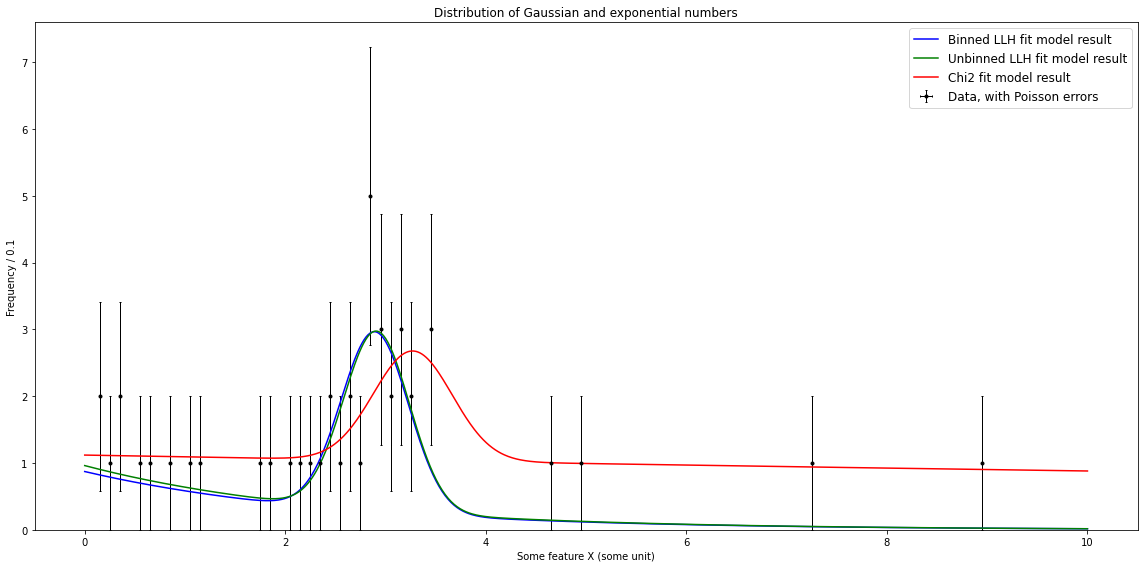

In [125]:
#Warnings:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")   
if (not minuit_bllh.fmin.is_valid) :
    print("  WARNING: The Binned Likelihood fit DID NOT converge!!! ")    
if (not minuit_ullh.fmin.is_valid) :
    print("  WARNING: The Unbinned Likelihood fit DID NOT converge!!! ")

#Results:
for name in minuit_chi2.parameters :
    chi_value, chi_error = minuit_chi2.values[name], minuit_chi2.errors[name]
    bllh_value, bllh_error = minuit_bllh.values[name], minuit_bllh.errors[name]
    ullh_value, ullh_error = minuit_ullh.values[name], minuit_ullh.errors[name]
    print(f"{name}:")
    print(f"Chi2: fit = {chi_value:.5f} +/- {chi_error:.5f}")
    print(f"Binned LLH: fit = {bllh_value:.5f} +/- {bllh_error:.5f}")
    print(f"Unbinned LLH: fit = {ullh_value:.5f} +/- {ullh_error:.5f}")

#Goodness of fit:         i.e The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value
print("Goodness of fit:")
print(f"Chi2 value: {minuit_chi2.fval:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Chi_Prob:5.3f}")
print(f"Binned LLH value: {minuit_bllh.fval:.1f}")
print(f"Unbinned LLH value: {minuit_ullh.fval:.1f}")
          


#Plot:
fig, ax = plt.subplots(figsize=(16, 8))  
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_bllh.values[:]), '-b', label='Binned LLH fit model result') 
ax.plot(x_axis, fit_pdf(x_axis, *minuit_ullh.values[:]), '-g', label='Unbinned LLH fit model result') 
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result')
ax.set(xlabel="Some feature X (some unit)", # the label of the y axis
       ylabel="Frequency / 0.1",  # the label of the y axis
       title="Distribution of Gaussian and exponential numbers", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero
ax.legend(loc='upper right', fontsize=12); # could also be # loc = 'upper right' e.g.
fig.tight_layout()

# Questions:

This exercise is meant for you to see to what extend the three fitting methods give the same results when varying the input parameters, especially when the number of signal and background events is low, and also when the binning is (too) coarse.

1) Start by drawing all three fits on top of the data. Do they (by eye) give the same result, and does the fit generally look "good"? How do you judge that? Also, compare the fitted values of the three fits, and see if they agree within uncertainties?

Looking good. Chi2_reduced~1 and all of the fits lies on top of each other. Parameters close to true values and almost within the uncertainties.  

2) Now repeat question 1) for lower statistics cases, for example Ngauss = 20 and Nexp = 50. See to what extend the different methods yields reasonable results (i.e. in accordance with the input values). You will encounter problems to be mended by yourself, such as empty bins (should not be passed to the ChiSquare dividing by "observed events", but is fine for the LLH fits) and poor initial values.
Possibly also alter the number of bins to 50 or 25 - is that a good choice? Why/why not?

Chi2 totally breaks down for low statistics. LLH is very consistent. Binned and unbinned agree quite well.


---

### Advanced question:

3) Knowing the PDFs used for producing the data, try to see, if you can produce a goodness-of-fit measure for the unbinned likelihood fit by repeating this type of fit many times on (re-)simulated data.

4) Improve on the printing of results on the plots to better align and have a choice of decimals :-)

# Learning points:

The exercise is meant as an illustration of the three main fitting paradigms:
1. ChiSquare (binned)
2. Likelihood (binned)
3. Likelihood (unbinned)

While the ChiSquare is almost always recommendable to start out with, low statistics makes it non-optimal. If possible, use an unbinned likelihood, and if the data is already binned, use a binned likelihood.